
## Introduction

I am going to use **ULMFiT** on "Twitter US Airline Sentiment" dataset to determine the mood of passengers after flights.

Why this problem can be challenging:


*   The model has already been pretrained on Wikitext-103, a dataset of 28k preprocessed articles consisting of 103 Million words. Hence, the model is adjusted for longer sequences (hundreds or thousands of words) rather than just 140 symbols. By the way, Twitter doubled its character count from 140 to 280 characters in 2017, but it makes no difference for us since the dataset was scraped in 2015.
*   Tweets are usually informal, so the model can encounter slang, illiterate sentences, or emoji, which can aggravate the accuracy.



## Import Dependencies

In [0]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

from fastai.text import * 

%matplotlib inline 

## Uploading data

In [2]:
# Connecting collab to the google drive
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
full_dataset = pd.read_csv("/gdrive/My Drive/ULMFiT_Sentiment/ULMFiT_Sentiment/data/Tweets.csv")

In [7]:
full_dataset.shape

(14640, 15)

In [0]:
full_dataset = pd.DataFrame(full_dataset[~(full_dataset['airline_sentiment'] == 'neutral')])

## Exploring data

In [9]:
full_dataset.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [0]:
full_dataset.shape

(14640, 15)

The dataset contains 14640 observations and 15 variables. 

For sentiment analyse we need only 'text' and 'airline_sentiment' columns.

In [0]:
full_dataset.info(memory_usage = "deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 10.7 MB


We have 11 categorical and 4 continuous features.

#### Checking the distribution of the target variable

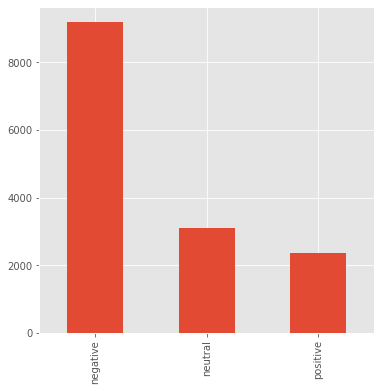

In [0]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(6,6))

full_dataset['airline_sentiment'].value_counts().plot(kind='bar', legend = False, ax=ax)

The dataset is unbalanced, which may affect classification accuracy

#### Creating a word cloud for every sentiment group

In [0]:
# Creating a dictionery {sentiment_name : all the text in the sentiment group}

sentiment_texts = {sentiment : " ".join(tweet for tweet in sentiment_df.text)
     for sentiment, sentiment_df in full_dataset.groupby('airline_sentiment')}

In [0]:
sentiment_texts.keys()

dict_keys(['negative', 'neutral', 'positive'])

In [0]:
stopwords = set(STOPWORDS)
# I omitted the names of the companies since they are used in every tweet
stopwords.update(["united","SouthwestAir","USAirways","JetBlue","AmericanAir","VirginAmerica","co","flight","will"])

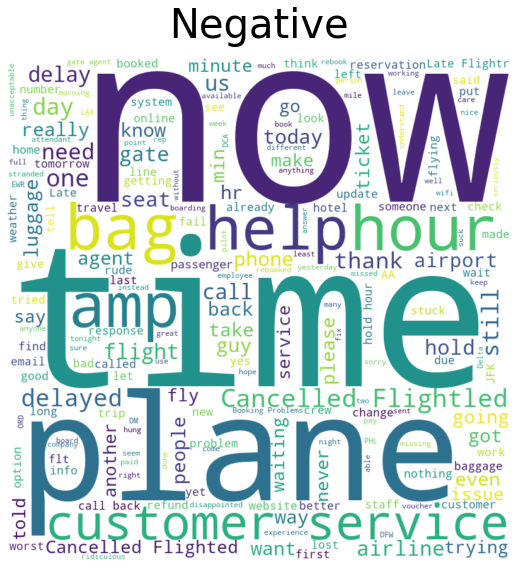

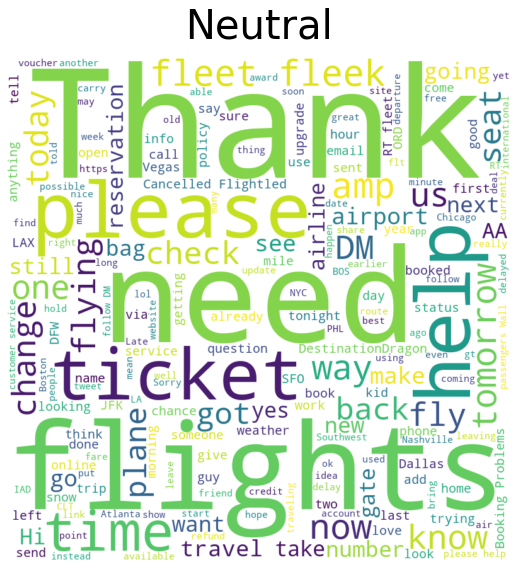

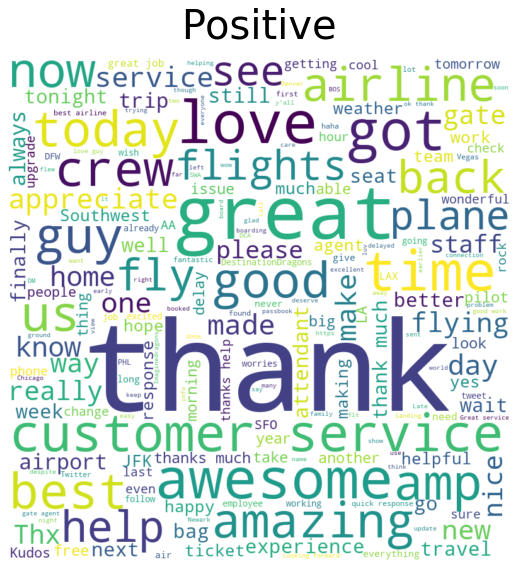

In [0]:
# Create and generate a word cloud image
for sentiment, text in sentiment_texts.items():

    wordcloud = WordCloud(stopwords=stopwords, width = 800, height = 800,background_color="white", min_font_size = 10).generate(text)
    
    # Display the generated image:
    plt.figure(figsize = (7, 7), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad = 0) 
    plt.title(sentiment.capitalize(), pad = 20,fontdict = {'fontsize' : 40,"color" : "black"})
    plt.show() 

As expected, in negative tweets most common words are connected to "customer service", "delay", "time" etc.

And in positive there are lot of words like "thank", "awesome". 

#### People mostly retweet negative tweets

In [0]:
full_dataset.groupby("airline_sentiment")["retweet_count"].sum()

airline_sentiment
negative    857
neutral     189
positive    164
Name: retweet_count, dtype: int64

It makes sense since bad news spreads faster.

#### The main reason of bad tweets

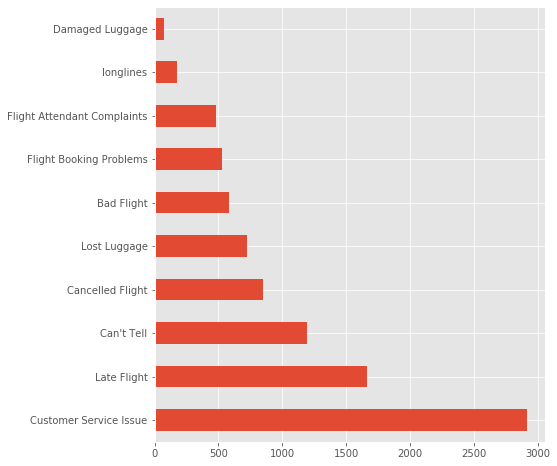

In [0]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(7,8))

full_dataset['negativereason'].value_counts().plot(kind='barh', legend = False, ax=ax)

Most negative tweets are connected to "Cursomer service Issue", which just proofs the word cloud

#### Distribution of the airlines

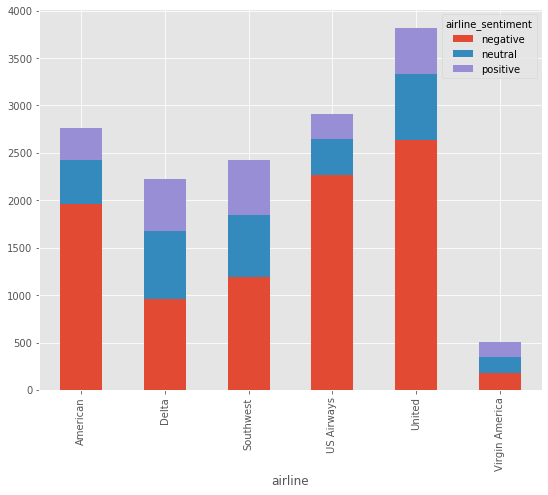

In [0]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(9,7))

full_dataset.groupby(['airline', 'airline_sentiment']).size().unstack().plot(
                            kind='bar', legend = True, ax=ax, stacked = True)

The most frequently mentioned "United" airline. Moreover, almost half of the tweets for each company consist of negative tweets, which is not surprising since when people are pleased they want to change nothing, but when they are unsatisfied, people try to get refund and have their problems solved.

#### When did people complain most often?

In [0]:
# Changing the column data type to datetime
full_dataset['tweet_created'] = pd.to_datetime(full_dataset['tweet_created']) 

In [0]:
# Extract only YYYY-MM-DD
date_tweet_created = pd.Series([date.date() for date in full_dataset['tweet_created']])
date_tweet_created[:3]

0    2015-02-24
1    2015-02-24
2    2015-02-24
dtype: object

In [0]:
# Concatenate "airline_sentiment"  with dates into one dataframe
date_and_sentiment_df = pd.concat([full_dataset['airline_sentiment'],date_tweet_created], axis=1,keys = ["airline_sentiment","tweet_created"])
date_and_sentiment_df.head()

,airline_sentiment,tweet_created
0,neutral,2015-02-24
1,positive,2015-02-24
2,neutral,2015-02-24
3,negative,2015-02-24
4,negative,2015-02-24


In [0]:
# Calculate the amount of negative tweets for every date and sort them.
date_and_sentiment_df[date_and_sentiment_df['airline_sentiment'].str.contains("negative")].groupby('tweet_created').count(
                                                                    ).sort_values(by = "airline_sentiment",ascending=False)

,airline_sentiment
tweet_created,
2015-02-22,2266
2015-02-23,1919
2015-02-21,1049
2015-02-17,838
2015-02-20,835
2015-02-24,781
2015-02-19,751
2015-02-18,736
2015-02-16,3


The largest number of complaints was received on February 22

#### Text length stats

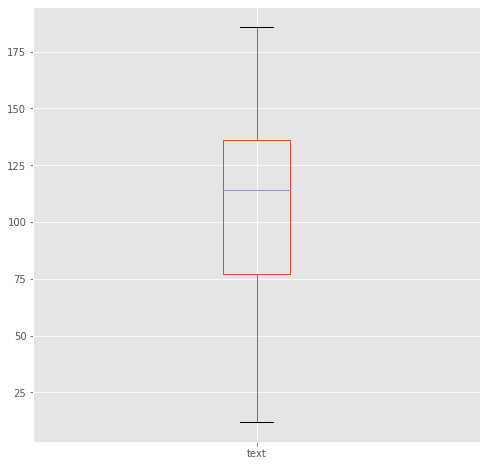

In [0]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(8,8))

full_dataset['text'].str.len().plot(kind='box', legend = False, ax=ax)

In [0]:
full_dataset['text'].str.len().describe()[['mean','min','max']]

mean    103.822063
min      12.000000
max     186.000000
Name: text, dtype: float64

The shortest tweet contains 12 characters and the longest one 189, and in general mean tweet length is 104 characters.

But something is wrong here, I mentioned that the max length of a tweet is 140. 
Let's check that very long tweet.

In [0]:
the_longest_tweet = full_dataset[full_dataset['text'].str.len()==186]
the_longest_tweet

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
10405,569328854948573187,positive,0.6925,NaN,0.0,US Airways,NaN,zfelice,NaN,0,"@USAirways Eyyyy! Cancelled Flightlations, Fli...",NaN,2015-02-21 18:52:31 -0800,"This Ain't Chicago, Tennessee",Central Time (US & Canada)


In [0]:
the_longest_tweet.iloc[0].text

"@USAirways Eyyyy! Cancelled Flightlations, Flight Booking Problemss, reFlight Booking Problemss, but y'all got me on the same flight out tonight (not tomorrow) &amp; the FC upgrade. Thx!"

It seems that the tweet has already been formatted. They on purpose inserted phrases like "Booking Problems", "Cancelled Flight", that's why the tweet is longer. It might have been done to make the classification easier.

#### Removing duplicates

In [0]:
full_dataset.duplicated().any()

True

In [0]:
full_dataset.drop_duplicates(inplace = True) 

## Creating a language model

In [0]:
path = "/gdrive/My Drive/ULMFiT_Sentiment/ULMFiT_Sentiment/data/"
bs = 70
random_state = 227

Splitting the dataset into the following parts:
*   60% - train set
*   20% - validation set
*   20% - test set


In [0]:
train, validate, test = np.split(full_dataset.sample(frac=1), [int(.6*len(full_dataset)), int(.8*len(full_dataset))])

#### Language model data bunch

In [12]:
language_model_data_bunch = TextLMDataBunch.from_df(path,
                        train_df=train,
                        valid_df=validate,
                        text_cols="text",
                        max_vocab=60000,
                        min_freq=2)

language_model_data_bunch.show_batch()

idx,text
0,"xxbos @united perhaps you could fix this ? https : / / t.co / 72rmpkogwu and this https : / / t.co / xxunk # xxunk xxbos xxmaj looking forward to using xxmaj passbook when i fly @southwestair in a few weeks ! xxbos @jetblue xxmaj no , he did n't have more info . i was more xxunk by the way previous rep treated me . how she can"
1,about an update with real xxunk waiting on xxmaj tarmac in xxmaj philadelphia . xxbos @americanair ... is this how you want to treat your platinum ( and two gold ) flyers ? ? xxbos @usairways xxmaj need help with a flight . xxmaj weather + funeral = tough combination . xxmaj on hold for over an hour . xxmaj please ? xxbos @americanair check on what ? xxmaj our
2,"my moms flight landed at xxunk and it lied xxbos @usairways absolutely worst experience of my life at xxup phl . 6 hrs , 1 failed departure , 3 gates , and xxup zero communication or help ! ! xxbos @americanair xxmaj thank you for the response , we got it resolved at the counter . xxbos @united i already follow you . xxmaj one of you xxunk agents rebooked"
3,xxbos @americanair i understand the need to xxunk the lavatory xxunk freezing but why no policy on checking that before boarding ? smh come on ... xxbos @americanair so you fail again flight to rdu sitting waiting on flight attendants . your logistics are not good xxbos @southwestair my flight was xxmaj cancelled xxmaj flighted for tomorrow and hold times are long can i xxmaj cancelled xxmaj flight a leg
4,"seats . xxmaj stewardess asked for my age & & i said 30 . xxmaj we xxunk . # xxunk # xxunk xxbos @jetblue needs to get its act together in # xxup phx xxbos @americanair xxmaj no , it would n't let me complete transaction because it was one way from xxmaj barbados to xxup nyc xxbos @united xxmaj xxunk 777 xxmaj star xxmaj alliance short finals xxunk xxup"


In [13]:
len(language_model_data_bunch.train_ds.vocab.itos)

4232

Now we have a sorted frequency dictionary with 4,992 words inside. Only words that have occurred more than two times have been added to the dictionary.

(The most frequent word has index 0, next word has index 1, etc) 

Let's check top 20 most frequent words.

In [0]:
language_model_data_bunch.train_ds.vocab.itos[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.',
 'to',
 'i',
 'the',
 '!',
 '?',
 'a',
 '/',
 'you',
 ',',
 'for']

Meaning of some tokens:

*   xxbos: Begining of a sentence
*   xxfld: Represent separate parts of a document like title, summary etc., each one will get a separate field and so they will get numbered (e.g. xxfld 1, xxfld 2).
*   xxup: If there's something in all caps, it gets lower cased and a token called xxup will get added to it. Words that are fully capitalized, such as “I AM SHOUTING”, are tokenized as “xxup i xxup am xxup shouting“
*   xxunk: token used instead of an uncommon word.
*   xxmaj: token indicates that there is capitalization of the word. “The” will be tokenized as “xxmaj the“.
*   xxrep: token indicates repeated word, if you have 29 ! in a row, (i.e. xxrep 29 !).	


In [0]:
print(f'Original:\n {full_dataset[full_dataset.text.str.contains("has passbook support")].text.iloc[0]}')
print(f'Preprocessed:\n {language_model_data_bunch.train_ds[10][0]}')
print(f"Numeric representation:\n {language_model_data_bunch.train_ds[10][0].data}")

Original:
 @SouthwestAir iPhone app now has passbook support! Whoot! It's the little things in life... 😜
Preprocessed:
 xxbos @southwestair iphone app now has passbook support ! xxmaj xxunk ! xxmaj it 's the little things in life ... 😜
Numeric representation:
 [   2   31 1445  409   61  109  887  809   13    5    0   13    5   30   42   12  486  505   29  571   66 1854]



Also FastAi has already preprocessed the text.

It tokenized it, and created a numeric representetion, which just the index of a word in the dictionary.







In [0]:
language_model_data_bunch.save('data_lm_export.pkl')
#language_model_data_bunch = load_data("data_lm_export.pkl")

#### Language model learner

In [14]:
language_model = language_model_learner(language_model_data_bunch, AWD_LSTM, drop_mult=0.5, pretrained=True)

The language model is based on AWD_LSTM architecture, which is a multi-layer bi-LSTM network without attention and with different dropout layers, such as "weight dropout", "input dropout", etc.

Also, the model has already been pretrained on Wikitext-103 dataset.

In [0]:
for i,layer in enumerate(language_model.layer_groups):
  print(40*"=",f"Layer {i}",40*"=","\n",layer)

======================================== Layer 0 ======================================== 
 Sequential(
  (0): WeightDropout(
    (module): LSTM(400, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
======================================== Layer 1 ======================================== 
 Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
======================================== Layer 2 ======================================== 
 Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 400, batch_first=True)
  )
  (1): RNNDropout()
)
======================================== Layer 3 ======================================== 
 Sequential(
  (0): Embedding(4992, 400, padding_idx=1)
  (1): EmbeddingDropout(
    (emb): Embedding(4992, 400, padding_idx=1)
  )
  (2): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=4992, bias=True)
    (output_dp): RNNDropout()
  )
)


As the input the embedding layer takes one-hot-encoded vector with size 4928 (the dictionary size), and as the output, it creates the representetion of the word as a dense vector with 400 element.

The whole model is freezed right now, so we are going to train only last layer.

#### Looking for suitable learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


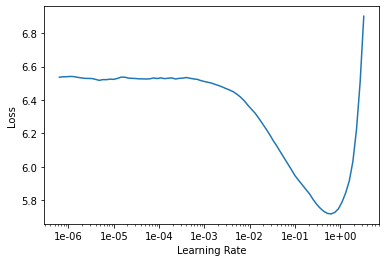

In [15]:
language_model.lr_find()
language_model.recorder.plot()

#### Tuning the LM

In [0]:
lr = 2e-2

In [17]:
language_model.fit_one_cycle(1, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.761994,4.020962,0.245552,00:08


The benefits of ULMFiT includes:

*   discriminative finetuning - *propose to tune each layer with different learning rates.*
*   triangular learning rate - *start with a small learning rate, then sharply increase and gradually decrease in the end*
*   gradual unfreezing - *unfreeze one more layer per one epoch*

Although in the paper it is recommended to use triangular learning rate, we are going to use cosine variant of it since with this approach, the results are better.


By the way, `fit_one_cycle()` has already implemented  cosine learning rate inside. We can plot the learning rate graph to see.


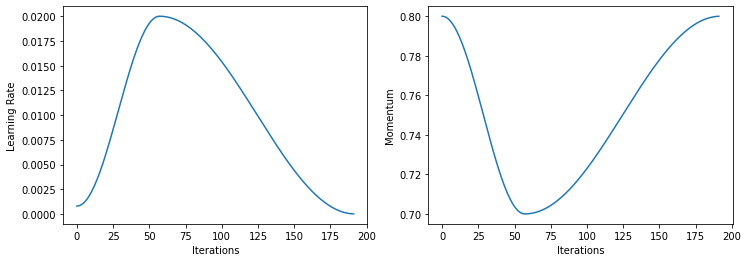

In [0]:
language_model.recorder.plot_lr(show_moms=True)

In [18]:
language_model.freeze_to(-2)
language_model.fit_one_cycle(1, lr/2.6, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.929161,3.822974,0.267905,00:08


In the paper it is suggested to use `previous_layer_learning_rate/2.6` for every hidden layer.

In [19]:
language_model.freeze_to(-3)
language_model.fit_one_cycle(1, (lr/2.6**2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.677210,3.741243,0.278763,00:08


Before unfreezing all the layers, let's take a look at the learning rate curve again.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


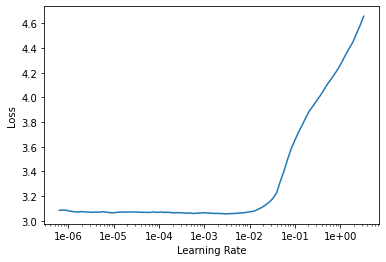

In [0]:
language_model.lr_find()
language_model.recorder.plot()

In [20]:
language_model.unfreeze()
language_model.fit_one_cycle(7, slice(1e-04,1e-03), moms=(0.9,0.8))

epoch,train_loss,valid_loss,accuracy,time
0,3.496478,3.738614,0.279544,00:08
1,3.477483,3.729062,0.279990,00:08
2,3.433474,3.718663,0.281409,00:09
3,3.374260,3.713603,0.281553,00:09
4,3.317997,3.714136,0.281840,00:09
5,3.280824,3.716456,0.281186,00:09
6,3.248673,3.715759,0.281537,00:09


By using `slice(1e-04,1e-03)`, we are implementing discriminative finetuning technique since it applies `1e-04`for the first layer and `1e-03` for the last, and evenly distributes lr for all the other layers.

Accuracy = 0.29 means the model is guessing the next word of the tweet  correctly about a third of the time. That sounds like a pge model is doing pretty well.retty high number. So it’s a good sign that my language model is doing pretty well.

In [0]:
#language_model.save('fine_tuned')
# Saving the language model and its encoder
language_model.save_encoder('fine_tuned_enc_binary_clas')
#data_lm = load_data(path, 'data_lm_export.pkl')

## Creating a classifier

#### Creating a classifier model data bunch

In [21]:
classifier_data_batch = TextClasDataBunch.from_df(path,
                        train_df=train,
                        valid_df=validate,
                        text_cols="text",label_cols="airline_sentiment",
                        vocab=language_model_data_bunch.train_ds.vocab, bs=bs)

classifier_data_batch.show_batch()

text,target
xxbos @southwestair xxmaj the xxmaj fact xxmaj that u xxmaj see xxmaj black xxmaj history xxmaj month 12 xxmaj months a xxmaj year xxmaj is xxmaj xxunk ! xxmaj we xxup will xxup be xxmaj an xxmaj xxunk xxmaj base xxmaj for xxmaj corp. xxmaj like u xxmaj in xxmaj future !,positive
"xxbos @usairways e xxrep 4 y ! xxmaj cancelled xxmaj flightlations , xxmaj flight xxmaj booking xxmaj problemss , reflight xxmaj booking xxmaj problemss , but y' all got me on the same flight out tonight ( not tomorrow ) & & the xxup fc upgrade . xxmaj thx !",positive
xxbos @united - xxup seriously it 's 2015 ? ! ? ! xxup no wifi on a 5hr flight from xxup cle - xxup sfo # 1589 . xxmaj you 're the xxup only airline w / out wifi ... and pls no ' xxunk ' xxup bs .,negative
"xxbos @jetblue i ❤ ️ xxmaj jetblue but i was on flt xxunk from fll to sfo . xxunk off was over 1 hr xxmaj late xxmaj flight , div to phx & & got in 2 hrs xxmaj late xxmaj flight . xxmaj what will be done ?",negative
xxbos @americanair xxmaj aww xxmaj thanks xxup aa .. xxup dfw was on xxup xxunk up here this xxup am .. so i understand .. xxmaj btw xxup xxunk is my xxmaj airline when i m able to xxunk .. xxmaj love you guys . : ),positive


Saving the preprocessed data bunches

In [0]:
classifier_data_batch.save('data_clas_export.pkl')
#data_clas = load_data(path, 'data_clas_export.pkl', bs=bs)

## Tuning the classifier

In [0]:
classifier = text_classifier_learner(classifier_data_batch, AWD_LSTM, drop_mult=0.5,bptt=70,max_len=200)



*   `bptt ` is the number of tokens you read before trying to predict the next token
*   `max_len` is max len of a sequence




In [0]:
for i,layer in enumerate(classifier.layer_groups):
  print(40*"=",f"Layer {i}",40*"=","\n",layer)

======================================== Layer 0 ======================================== 
 Sequential(
  (0): Embedding(4992, 400, padding_idx=1)
  (1): EmbeddingDropout(
    (emb): Embedding(4992, 400, padding_idx=1)
  )
)
======================================== Layer 1 ======================================== 
 Sequential(
  (0): WeightDropout(
    (module): LSTM(400, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
======================================== Layer 2 ======================================== 
 Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
======================================== Layer 3 ======================================== 
 Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 400, batch_first=True)
  )
  (1): RNNDropout()
)
======================================== Layer 4 ======================================== 
 Sequential(
  (0): PoolingLinearClassifier(
    (layers): Sequential(
      (0): B

Loading the embedding layer from our LM to the classifier

In [0]:
classifier.load_encoder('fine_tuned_enc_binary_clas')

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


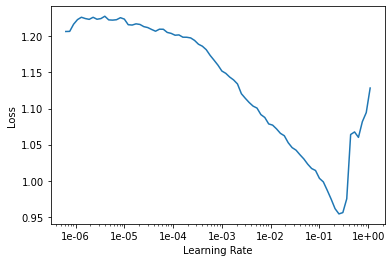

In [0]:
classifier.lr_find()
classifier.recorder.plot()

In [0]:
lr = 5e-03

In [27]:
classifier.fit_one_cycle(1, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.397438,0.293300,0.899047,00:11


Unfreezing last two layers and tune again

In [28]:
classifier.freeze_to(-2)
classifier.fit_one_cycle(1, slice(lr/(2.6),lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.305866,0.210974,0.926776,00:11


Unfreezing last 3 layers

In [30]:
classifier.freeze_to(-3)
classifier.fit_one_cycle(1, slice((lr/(2.6**2)),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.244159,0.193571,0.927210,00:13


Let's unfreeze what's left

In [31]:
classifier.unfreeze()
classifier.fit_one_cycle(4, slice(lr/(2.6**3),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.199708,0.182691,0.930243,00:12
1,0.186755,0.177788,0.931542,00:13
2,0.138305,0.164581,0.941941,00:13
3,0.104273,0.170126,0.938908,00:12


A little bit more and the model would start overfitting. 

In [0]:
classifier.save("full_tuned_classifier")

In [0]:
#classifier.load("full_tuned_classifier")

#### Applying the classifier on the test dataset

In [0]:
# Make predictions for the test dataset
test_predictictions = test['text'].apply(lambda row: str(classifier.predict(row)[0]))

In [33]:
print("Test Accuracy: ", accuracy_score(test['airline_sentiment'], test_predictictions))

Test Accuracy:  0.9294066695539195


Human agreement baseline is 80-85%. So our model works not so bad. Especially if we take into account the fact that we have 3 target classes, which greatly complicates the classification.

## Confusion matrix

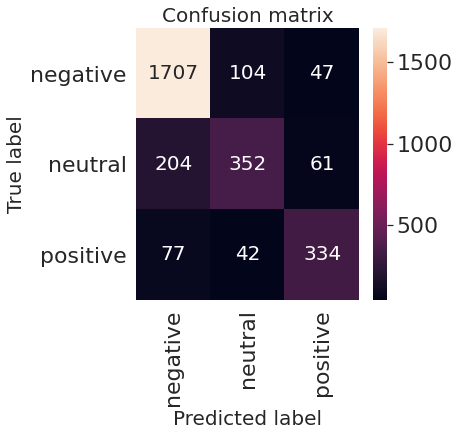

In [0]:

sns.set(font_scale=2)

LABELS = ['negative', 'neutral', 'positive']

confusion_matrix = confusion_matrix(test['airline_sentiment'], test_predictictions)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

The model often confuses neutral and negative tweets. Neutral tweets are tricky, even a person has difficulty with distinguishing them.

## Conclusion

The result could be improved by using the following technics:


*   Despite the fact that the hyper parameters are selected quite well, it might help to try playing with the dropouts and momentums, which theoretically can reduce the overfitting that will allow us to use more epoch to train the model.

*   Usually deep neural networks pick up features themselves, but we can try creating new features like `is_night` or `tweet_len`. First of all, sleepy people are usually angry, and when people are displeased, they write long tweets to show their displeasure.

Problem that we can't easily add new features to our classifier, but we can have 2 independent classifiers for the text data and the binary/numeric data, both of which have exhibited a good predictive performance independently, and then add a 2 layer classifier on top of the output of the first 2 classifiers.

